In [24]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
from pylab import *

In [69]:
def create_wildfire_df(PATH):
    '''
    PATH: Linux path to sqlite for wildfire database
    Output:
        dataframe: of wildfire with the following columns:
        LATITUDE
        LONGITUDE
        STATE
        date
        fire_size
        fire_year
        fire_month
        fire_total (This is total fire in a particular latitude, longitude, fire_year and fire_month)
    '''
    assert(os.path.exists(PATH)),"Incorrect file path"
    conn = sqlite3.connect(PATH)
    data_dates = pd.read_sql_query("SELECT fire_year, discovery_date FROM fires;", conn)
    data_size = pd.read_sql_query("SELECT fire_size, fire_size_class FROM fires;", conn)
    data_location = pd.read_sql_query("SELECT latitude, longitude, state FROM fires;", conn)
    date = pd.read_sql_query("select datetime(DISCOVERY_DATE) as DISCOVERY_DATE from fires;", conn)
    data_dates_arr = date['DISCOVERY_DATE']
    fire_year_arr = data_dates['FIRE_YEAR']
    fire_size_arr = data_size['FIRE_SIZE']  
    #Create a dataframe df 
    df = data_location
    df['date'] = data_dates_arr
    df['fire_size'] = fire_size_arr
    df['fire_year'] = fire_year_arr
    df['fire_month'] = pd.DatetimeIndex(df['date']).month
    #Converted Lat and Long to int to remove the exact precision
    df['LATITUDE'] = df['LATITUDE'].round(2)
    df['LONGITUDE'] = df['LONGITUDE'].round(2)
##Compute total fire based on Latitude, Longitude, fire_year and fire_month
    df['fire_total'] = df.groupby(['LATITUDE','LONGITUDE', 'fire_year','fire_month'])['fire_size'].transform(sum)
    
    return df

In [70]:
def large_fire_coord(state, fire_size, df):
    '''
    Input: 
        state: The state we want to focus on.
        df: Input dataframe
        fire_size: fire size above which is considered large
    Output:
        lat_min,lat_max,long_min,long_max: the coordinates with fires above fire_size in state 'state'
    '''
    #print(state)
    df = df.query("fire_total >= fire_size and STATE == @state")
    lat_max = df['LATITUDE'].max()
    lat_min = df['LATITUDE'].min()
    long_max = df['LONGITUDE'].max()
    long_min = df['LONGITUDE'].min() 
    return lat_min,lat_max,long_min,long_max

In [71]:
PATH = '../../188-million-us-wildfires/FPA_FOD_20170508.sqlite'
fire_df = create_wildfire_df(PATH)

In [72]:
def process_df(coords, fire_size, df):
    '''
    Input: 
        coords: A tuple of lat_min,lat_max,long_min,long_max in which we need to find wild fires
        Find sum of fire occuring within the location, for a given year and month
    
    '''
    lat_min,lat_max,long_min,long_max = coords
    #print(lat_min,lat_max,long_min,long_max)
    df_new = df.query("LATITUDE >= @lat_min and LATITUDE <= @lat_max and LONGITUDE >= @long_min and LONGITUDE <= @long_max and fire_total>=@fire_size")
    #print(df_new)
   # df_new['fire_total_area'] = df_new.groupby(['fire_year','fire_month'])['fire_total'].transform(sum)
   # df_new = df_new.sort_values('fire_total', ascending=False).drop_duplicates(['fire_year','fire_month'])
   # df_final = df_new[['fire_year','fire_month','fire_total_area']]
    return df_new

In [73]:

coords = large_fire_coord('AK',100000,fire_df)
fire_df_local = process_df(coords,100000,fire_df)

In [74]:
lat_fire = np.array(fire_df_local['LATITUDE'].tolist())
lon_fire = np.array(fire_df_local['LONGITUDE'].tolist())+360

In [75]:
lon_fire.shape

(79,)

In [11]:
import os 
import numpy as np
import iris   
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline
import iris.coord_categorisation as cat
import pandas as pd
from iris.analysis import Aggregator

In [12]:
def region_based_cube(cube,coords):
    '''
    Inputs:
        cube with latitude and longitude as coords
        coords: the region we want to extract from input cube
    Outputs: 
        A smaller cube within coords
    '''
    lat_min,lat_max,long_min,long_max = coords
    lat_cons = iris.Constraint(latitude = lambda x : lat_min < x < lat_max)
    if (long_min<0):
        long_min = long_min+360
    if(long_max <0) :
        long_max = long_max+360
    long_cons = iris.Constraint(longitude = lambda x : long_min < x < long_max)
    new_cube = cube.extract(lat_cons & long_cons)
    return new_cube

In [16]:
##Adding auxilary axis:
def get_decade(coord, value):
    date = coord.units.num2date(value)
    return date.year - date.year % 10
def get_year(coord, value):
    date = coord.units.num2date(value)
    return date.year

def get_month(coord, value):
    date = coord.units.num2date(value)
    return date.month


In [17]:
PATH_temp = os.path.join(os.getcwd(), "../../air.mon.mean.nc")
cube_temp = iris.load_cube(PATH_temp)
cat.add_categorised_coord(cube_temp, 'year', 'time', get_year)
cat.add_categorised_coord(cube_temp, 'month', 'time', get_month)
cube_local = region_based_cube(cube_temp,coords)

In [77]:
cube_mean = cube_local.collapsed(['year'], iris.analysis.MAX)

C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [78]:
cube_mean.coord('latitude')

DimCoord(array([69.75, 69.25, 68.75, 68.25, 67.75, 67.25, 66.75, 66.25, 65.75,
       65.25, 64.75, 64.25, 63.75, 63.25, 62.75, 62.25, 61.75, 61.25,
       60.75, 60.25, 59.75, 59.25, 58.75, 58.25, 57.75, 57.25, 56.75,
       56.25, 55.75, 55.25, 54.75, 54.25, 53.75, 53.25, 52.75, 52.25,
       51.75, 51.25], dtype=float32), standard_name='latitude', units=Unit('degrees'), long_name='Latitude', var_name='lat', attributes={'actual_range': array([ 89.75, -89.75], dtype=float32), 'coordinate_defines': 'center'})

In [79]:
np.unique(lat_fire)

array([60.44, 61.45, 61.98, 62.12, 62.3 , 62.4 , 62.53, 62.7 , 62.84,
       63.08, 63.2 , 63.42, 63.45, 63.47, 63.57, 63.59, 63.63, 63.65,
       63.82, 64.02, 64.1 , 64.12, 64.14, 64.22, 64.33, 64.35, 64.37,
       64.46, 64.47, 64.48, 64.64, 64.66, 64.67, 64.72, 64.73, 64.75,
       64.79, 64.9 , 64.93, 64.97, 64.98, 65.18, 65.27, 65.28, 65.44,
       65.52, 65.67, 65.71, 65.72, 65.75, 65.79, 65.8 , 65.87, 65.9 ,
       65.95, 65.98, 66.  , 66.16, 66.22, 66.3 , 66.48, 66.52, 66.72,
       66.73, 66.79, 66.83, 66.85, 66.91, 66.96, 67.1 , 67.21, 67.22,
       67.53, 69.05])

In [80]:
lat = cube_mean.coord('latitude').points
lon = cube_mean.coord('longitude').points

In [81]:
data = cube_mean.data

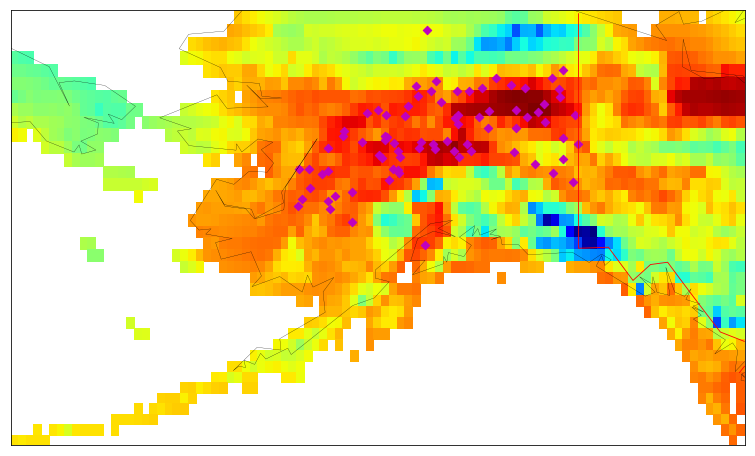

In [82]:
plt.figure(figsize=[15,8])
m=Basemap(projection='mill',lat_ts=10, \
  llcrnrlon=lon.min(),urcrnrlon=lon.max(), \
  llcrnrlat=lat.min(),urcrnrlat=lat.max(), \
  resolution='c')
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.85,color='red')
#xxx,yyy = meshgrid(lons,lats)
#x,y=m(xxx,yyy)
#print(y)
Lon,Lat = meshgrid(lon,lat)
x, y = m(Lon,Lat)
cs = m.pcolormesh(x,y,data,shading='flat',cmap=plt.cm.jet)
a,b = m(lon_fire,lat_fire)
scat = m.scatter(a,b,marker='D',color='m')